In [9]:
!pip install opendatasets

In [10]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/jessicali9530/lfw-dataset")

Skipping, found downloaded files in "./lfw-dataset" (use force=True to force download)



# Explore the dataset

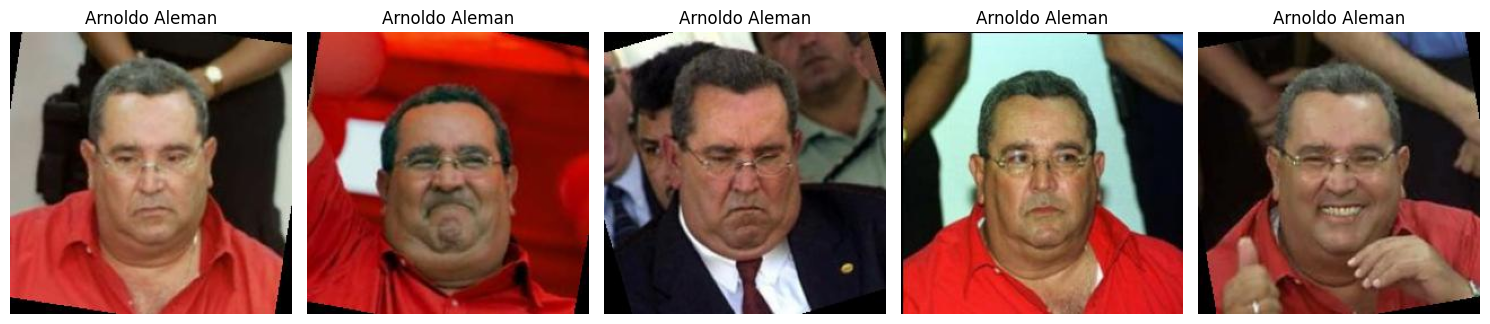

In [11]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Specify the directory to search for images
image_dir = "/content/lfw-dataset/lfw-deepfunneled"


def display_images(image_dir, num_images=5):
    image_files = []
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_files.append(os.path.join(root, file))

    if not image_files:
        print("No images found in the specified directory.")
        return

    fig, axes = plt.subplots(1, min(num_images, len(image_files)), figsize=(15, 5))

    for i in range(min(num_images, len(image_files))):
        img_path = image_files[i]
        try:
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].axis('off')

            # Extract and format the image name
            image_name = os.path.basename(img_path)
            name_parts = image_name.split("_")
            name = " ".join(name_parts[:-1])
            axes[i].set_title(name)
        except Exception as e:
            print(f"Error displaying image {img_path}: {e}")

    plt.tight_layout()
    plt.show()


display_images(image_dir)

In [12]:
import csv

def display_readme(filepath):
    try:
        with open(filepath, 'r', encoding='utf-8') as file:
            reader = csv.reader(file)
            for row in reader:
                print(','.join(row))  # Print each row as a comma separated string
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
    except Exception as e:
        print(f"An error occurred: {e}")

display_readme("/content/lfw-dataset/lfw_readme.csv")

Labeled Faces in the Wild
University of Massachusetts - Amherst

README contents:
--------------------------------

1. lfw-tgz - the database
2. training paradigms
   2a. Image Restricted Configuration
   2b. Unrestricted Configuration
   2c. test procedure
3. training, validation, and testing
   3a. View 1: development training/testing sets
   3b. View 2: performance testing configurations
   3c. pairs.txt file format
   3d. people.txt file format
4. additional details


1. lfw.tgz - the database
--------------------------------

The entire Labeled Faces in the Wild database can be downloaded as a
gzipped tar file.  After uncompressing, the contents of the database
will be placed in a new directory "lfw".  

Each image is available as "lfw/name/name_xxxx.jpg", where "xxxx" is
the image number padded to four characters with leading zeroes.  For
example, the 10th George_W_Bush image can be found as
lfs/George_W_Bush/George_W_Bush_0010.jpg.

There are a total of 13233 images and 5749 peo

# Install dependencies

In [13]:
# Install dependencies
!pip install tensorflow opencv-python matplotlib

# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Ensure GPU is enabled in Colab
assert tf.test.gpu_device_name(), "GPU not found"


In [14]:
!nvidia-smi

Wed Jan 29 20:31:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   70C    P0             33W /   70W |     102MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Check data

Skipping line with invalid indices: ['name', 'imagenum1', 'imagenum2', '']
Matched Pairs:


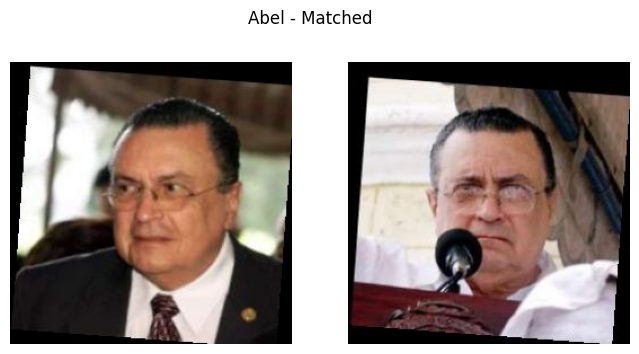

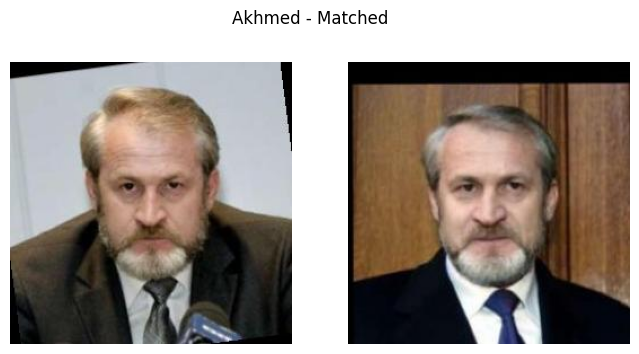

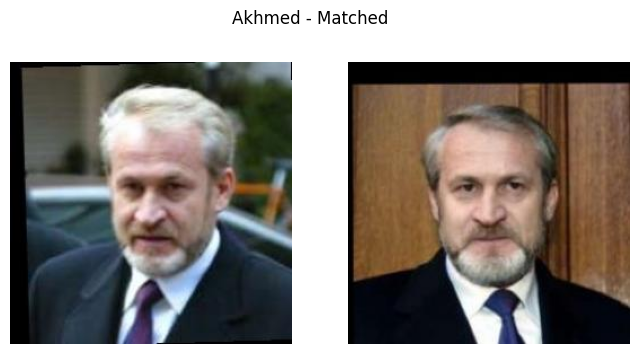

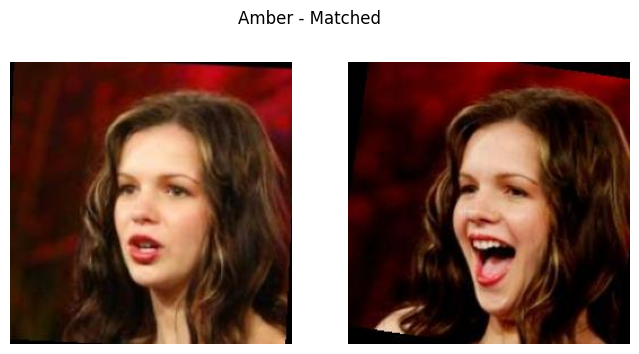

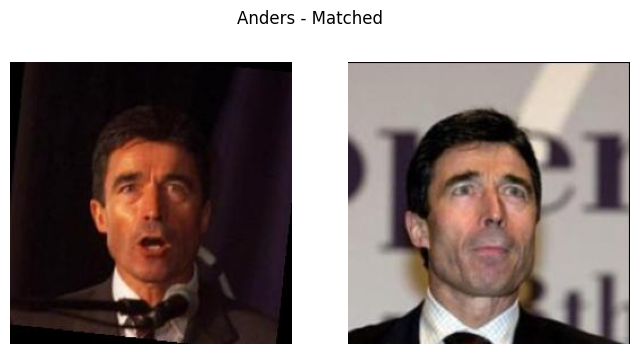


Mismatched Pairs:


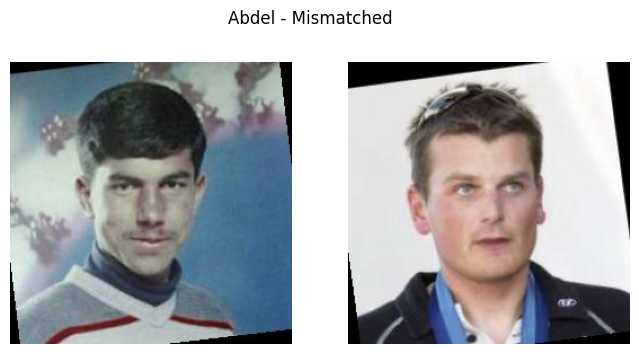

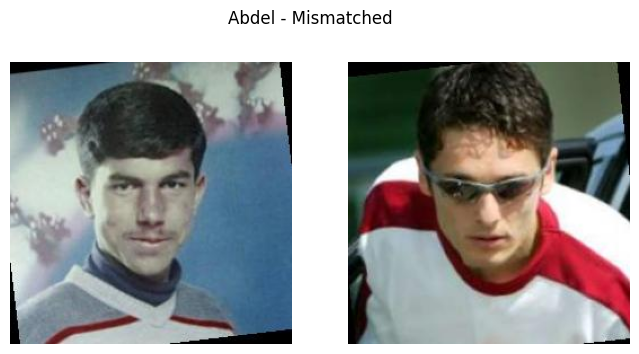

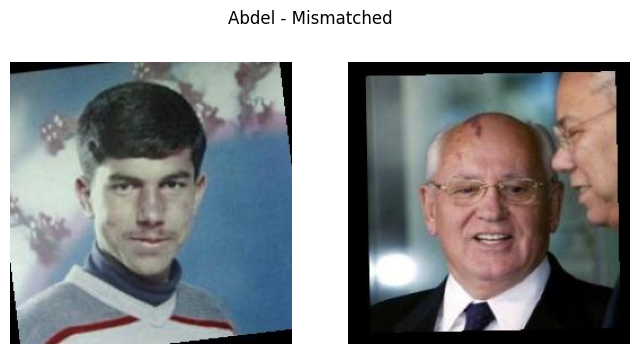

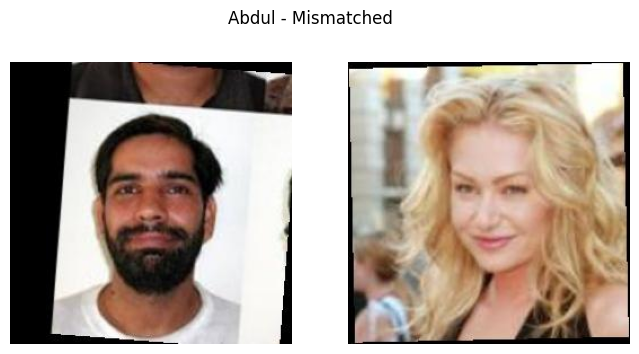

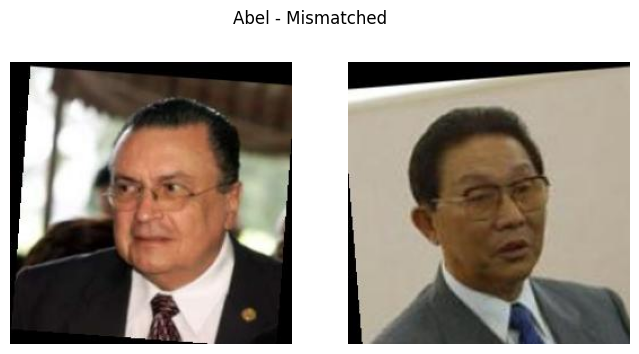

Skipping line with invalid indices: ['name', 'imagenum1', 'imagenum2', '']


In [43]:
import os
import csv
import matplotlib.pyplot as plt
from PIL import Image

pairs_file = "/content/lfw-dataset/pairs.csv"
image_folder = "/content/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled"

def load_images_from_pairs(pairs_file, image_folder):
    image_pairs = []
    with open(pairs_file, 'r') as f:
        lines = f.readlines()
        # Skip the header row (first line) if it exists
        start_index = 1 if lines[0].startswith('10,') else 0

        for i in range(start_index, len(lines)):
            pair_line = lines[i].strip().split(',')

            if len(pair_line) == 4 and pair_line[-1] == '':
                # Matched pair
                name, img1_idx, img2_idx = pair_line[:3]
                try:
                    img1_idx = int(img1_idx)
                    img2_idx = int(img2_idx)
                except ValueError:
                    print(f"Skipping line with invalid indices: {pair_line}")
                    continue

                # Construct paths with the person's subfolder (Corrected)
                img1_path = os.path.join(image_folder, name, f"{name}_{img1_idx:04}.jpg")
                img2_path = os.path.join(image_folder, name, f"{name}_{img2_idx:04}.jpg")
                image_pairs.append((img1_path, img2_path, 1))
            elif len(pair_line) == 4:
                # Mismatched pair
                name1, img1_idx, name2, img2_idx = pair_line
                try:
                    img1_idx = int(img1_idx)
                    img2_idx = int(img2_idx)
                except ValueError:
                    print(f"Skipping line with invalid indices: {pair_line}")
                    continue

                # Construct paths with the respective person's subfolders (Corrected)
                img1_path = os.path.join(image_folder, name1, f"{name1}_{img1_idx:04}.jpg")
                img2_path = os.path.join(image_folder, name2, f"{name2}_{img2_idx:04}.jpg")
                image_pairs.append((img1_path, img2_path, 0))
    return image_pairs

def display_pairs(image_pairs, num_pairs=5):
    matched_pairs = [pair for pair in image_pairs if pair[2] == 1]
    mismatched_pairs = [pair for pair in image_pairs if pair[2] == 0]

    # Display matched pairs
    print("Matched Pairs:")
    for i in range(min(num_pairs, len(matched_pairs))):
        img1_path, img2_path, _ = matched_pairs[i]
        display_image_pair(img1_path, img2_path, title="Matched")

    # Display mismatched pairs
    print("\nMismatched Pairs:")
    for i in range(min(num_pairs, len(mismatched_pairs))):
        img1_path, img2_path, _ = mismatched_pairs[i]
        display_image_pair(img1_path, img2_path, title="Mismatched")

def display_image_pair(img1_path, img2_path, title):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    img1 = Image.open(img1_path)
    img2 = Image.open(img2_path)

    axes[0].imshow(img1)
    axes[0].axis('off')
    axes[1].imshow(img2)
    axes[1].axis('off')

    name_with_surname = os.path.basename(img1_path).split("_")[0]


    if "_" in name_with_surname:
        first_name, last_name = name_with_surname.split("_", 1)
        full_title = f"{first_name} {last_name} - {title}"
    else:
        full_title = f"{name_with_surname} - {title}"

    fig.suptitle(full_title)
    plt.show()

image_pairs = load_images_from_pairs(pairs_file, image_folder)
display_pairs(image_pairs)

pairs = load_images_from_pairs(pairs_file, image_folder)

# Face detection

In [47]:
import cv2
import matplotlib.pyplot as plt

def detect_face(image_path):
    # Load the image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Use OpenCV's pre-trained face detector (Haar cascades)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    if len(faces) == 0:
        return None  # No faces found

    # Crop and return the first detected face
    (x, y, w, h) = faces[0]
    face = img[y:y + h, x:x + w]

    # Display original image and detected face side-by-side
    #fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 2 subplots

    # Display original image
    #axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    #axes[0].set_title("Original Image")
    #axes[0].axis('off')

    # Display detected face
    #axes[1].imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
    #axes[1].set_title("Detected Face")
    #axes[1].axis('off')

    #plt.show()

    return cv2.resize(face, (160, 160))  # Resize to (160, 160) for the face recognition model

image_path = "/content/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Adrien_Brody/Adrien_Brody_0012.jpg"
detect_face(image_path)


# Face embeddings

In [40]:
def create_face_embedding_model():
    base_model = MobileNetV2(input_shape=(160, 160, 3), include_top=False, weights='imagenet')
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)
    embedding_model = models.Model(inputs=base_model.input, outputs=x)
    embedding_model.trainable = False  # Freeze the pre-trained layers
    return embedding_model


face_embedding_model = create_face_embedding_model()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Comparison model

In [41]:
def create_comparison_model(embedding_model):
    input_1 = layers.Input(shape=(160, 160, 3))
    input_2 = layers.Input(shape=(160, 160, 3))

    embedding_1 = embedding_model(input_1)
    embedding_2 = embedding_model(input_2)

    # Compute cosine similarity
    distance = layers.Lambda(lambda tensors: tf.norm(tensors[0] - tensors[1], axis=-1, keepdims=True))([embedding_1, embedding_2])

    model = models.Model(inputs=[input_1, input_2], outputs=distance)
    return model

# Example usage:
comparison_model = create_comparison_model(face_embedding_model)


# Compile and train model

In [ ]:
def compile_and_train_model(model, pairs, epochs=10, batch_size=32):
    # Prepare data (pairs of images and labels)
    X1 = [detect_face(pair[0]) for pair in pairs]
    X2 = [detect_face(pair[1]) for pair in pairs]
    y = [pair[2] for pair in pairs]  # 1 for match, 0 for mismatch

    # Filter out None values (images where no face was detected)
    X1, X2, y = zip(*[(x1, x2, label) for x1, x2, label in zip(X1, X2, y) if x1 is not None and x2 is not None])

    # Convert to NumPy arrays
    X1 = np.array(X1)
    X2 = np.array(X2)
    y = np.array(y)

    # Train the model
    class_weights = {0: 1.0, 1: 5.0}
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit([X1, X2], y, epochs=epochs, batch_size=batch_size, class_weight=class_weights)

compile_and_train_model(comparison_model, pairs)


# Evaluation

In [52]:
def evaluate_model(model, test_pairs):
    # Prepare data (pairs of images and labels)
    X1_test = [detect_face(pair[0]) for pair in test_pairs]
    X2_test = [detect_face(pair[1]) for pair in test_pairs]
    y_test = [pair[2] for pair in test_pairs]

    # Filter out None values (images where no face was detected)
    X1_test, X2_test, y_test = zip(*[(x1, x2, label)
                                      for x1, x2, label in zip(X1_test, X2_test, y_test)
                                      if x1 is not None and x2 is not None])

    # Convert to NumPy arrays
    X1_test = np.array(X1_test)
    X2_test = np.array(X2_test)
    y_test = np.array(y_test)

    # Predict distances (lower is better for match)
    distances = model.predict([X1_test, X2_test])
    predictions = (distances < 0.5).astype(int)  # Threshold: 0.5 (can be adjusted)

    print(classification_report(y_test, predictions))

from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_pairs, test_pairs = train_test_split(pairs, test_size=0.2, random_state=42)  # Adjust test_size as needed

evaluate_model(comparison_model, test_pairs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 224ms/step
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       570
           1       0.00      0.00      0.00       612

    accuracy                           0.48      1182
   macro avg       0.24      0.50      0.33      1182
weighted avg       0.23      0.48      0.31      1182



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
